In [493]:
# default_exp vector_models_test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the Vector Models for the Whole Alphabet

> Creating the `VectorRenderLayer` models for the whole (with some possible exceptions) uppercase sans-serif alphabet. The parameters are based on the list [Sans-serif uppercase font parameters](https://docs.google.com/spreadsheets/d/1myiVDPCNNRzwTSw9VFKqdw26Bk8wPQNQXa9ix_EL_CA/edit?usp=sharing).

In [494]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## To Do

* Letter models
  * Convert weights to relative weigths based on a master value
  * Test variable scoping by rendering afresh each letter
* Gradient clipping so we can use a large enough LR to capture the small local variations in loss
  * See https://docs.fast.ai/callback.training.html#GradientClip
* Test thickness
* Fix learner shadow attribute

## Letter Model

### Constants

In [495]:
#export

DEFAULT_FONT_PARAM_SPECS = OrderedDict({
    "Height": PRANGE_NONZERO,
    "Slant": PRANGE_BIDIR,
    "Midline": PRANGE_DEFAULT,
    "Stroke width": PRANGE_STROKE,
    "Bowl curvature": PRANGE_DEFAULT, # Superness: 0: cross, 1: lozenge, 2: circle: Inf: square
    "Width, AV": PRANGE_NONZERO,
    "Width, BPR": PRANGE_NONZERO,
    "Width, D": PRANGE_NONZERO,
    "Width, EF": PRANGE_NONZERO,
    "Width, CGOQ": PRANGE_NONZERO, # NB. This is the final width for only O
    "Width, HNU": PRANGE_NONZERO,
    "Width, J": PRANGE_NONZERO,
    "Width, K": PRANGE_NONZERO,
    "Width, L": PRANGE_NONZERO,
    "Width, M": PRANGE_NONZERO,
    "Width, S": PRANGE_NONZERO,
    "Width, TZ": PRANGE_NONZERO,
    "Width, W": PRANGE_NONZERO,
    "Width, XY": PRANGE_NONZERO,
    "Width n difference from O, C": PRANGE_ASYM_S,
    "Width n difference from E, F": PRANGE_ASYM_S,
    "Width n difference from O, G": PRANGE_ASYM_S,
    "Offset x from symmetry, AXZ": PRANGE_BIDIR_S,
    "Overshoot, AMNVW": PRANGE_XSMALL, # An option is to allow negative values for this
    "Overshoot, CGJOSQ": PRANGE_XSMALL,
    "Crossbar y offset, A": PRANGE_BIDIR_H,
    "Crossbar y offset, B": PRANGE_BIDIR_H,
    "Crossbar y offset, G": PRANGE_BIDIR_H,
    "Crossbar y offset, P": PRANGE_BIDIR_H,
    "Crossbar y offset, R": PRANGE_BIDIR_H,
    "Crotch y offset, Y": PRANGE_BIDIR_H,
    "Crossbar length, G": PRANGE_DEFAULT,
    "Bar stem height, G": PRANGE_DEFAULT,
    "Bowl aspect ratio, BPR": PRANGE_DOUBLE,
    "Bowl aspect ratio, BPR": PRANGE_DOUBLE,
    "Bowl aspect ratio, D": PRANGE_DOUBLE,
    "Bowl aspect ratio, J": PRANGE_DOUBLE,
    "Bowl aspect ratio, U": PRANGE_DOUBLE,
    "Bowl distortion, BPR": PRANGE_ASYM_S,
    # "Bowl distortion, G": PRANGE_ASYM_S,
    "Bowl distortion, J": PRANGE_ASYM_S,
    "Upper bowl xn offset, B": PRANGE_ASYM_S,
    "Upper width n difference, E": PRANGE_ASYM_S,
    "Upper bowl ratio to lower, S": PRANGE_NONZERO,
    "Upper bowl xp offset, S": PRANGE_ASYM_S,
    "Upper width n difference, X": PRANGE_ASYM_S,
    "Upper width n difference, Z": PRANGE_ASYM_S,
    "Middle width n difference, E": PRANGE_ASYM_S,
    "Middle width n difference, F": PRANGE_ASYM_S,
    "Aperture, CGS": PRANGE_NONZERO,
    "Aperture, J": PRANGE_NONZERO,
    "Arm xn offset, K": PRANGE_ASYM_S,
    "Stem-arm connection height, K": PRANGE_DEFAULT,
    "Arm-leg connection location, K": PRANGE_DEFAULT,
    "Stem xp offset from vertical, M": PRANGE_ASYM_S,
    "Tail angle, Q": PRANGE_ANGLE_90,
    "Tail length, Q": PRANGE_NONZERO_H,
    "Tail-bowl connection location, Q": PRANGE_DEFAULT,
    "Tail inside fraction, Q": PRANGE_DEFAULT,
    "Leg xp offset, R": PRANGE_ASYM_S,
    "Leg-bowl connection location, R": PRANGE_DEFAULT,
    "Leg distortion, R": PRANGE_ASYM_H,
    # Not implemented bc it would too much work to sharpen all corners to match the behaviour
    # "Termination angle deviation, CGJS": PRANGE_ANGLE
    })

# Letter groups
# Crop the ends of strokes going beyond cap height or baseline
LETTERS_CROP_BOTH        = "AB DE FHI KLMN P R T VWXYZ"
LETTERS_CROP_TOP_ONLY    = "         J          U     "
# Pad vertex points by half stroke width
LETTERS_PAD_LEFT         = "ABCDEFGHIJKLMNOPQRS UVWXYZ"
LETTERS_PAD_RIGHT        = "ABCD  GHIJK MNOPQRS UVWXY "
LETTERS_PAD_TOP          = " BCDEFG       OPQRST     Z"
LETTERS_PAD_BOTTOM       = " BCDE G  J L  O Q S U    Z"
# The directions to apply overshoot to
LETTERS_OVERSHOOT_TOP    = "A C   G     MNO Q S       "
LETTERS_OVERSHOOT_BOTTOM = "  C   G  J   NO Q S UVW   "

# The bezier curvature value for a circle
CIRCLE_CURVATURE = 4 * (math.sqrt(2) - 1) / 3

### Utilities

In [496]:
#export

class BoundingBox(GetAttr):
    """A simple object to hold the coordinates for the bounding box of 
       letter vertices."""
    def __init__(self, 
        left: Tensor, 
        top: Tensor, 
        right: Tensor, 
        bottom: Tensor):
        self.top_lft = self.top_left     = concat_tensors(left, top)
        self.top_rgt = self.top_right    = concat_tensors(right, top)
        self.btm_lft = self.bottom_left  = concat_tensors(left, bottom)
        self.btm_rgt = self.bottom_right = concat_tensors(right, bottom)
        self.width   = right - left
        self.height  = bottom - top
        store_attr()
    def __repr__(self):
        return "\n".join(["BoundingBox"] + [f"- {x}: {getattr(self, x).item()}" for x in "left,top,right,bottom".split(",")])
    @classmethod
    def from_points(cls,
        p1: Tensor,
        p2: Tensor,
        **kwargs
        ):
        """Create a `BoundingBox` from top-left and bottom-right corner points."""
        return cls(left = p1[0], top = p1[1], right = p2[0], bottom = p2[1], **kwargs)

def get_bounding_box(
    p_height: Tensor, 
    p_width: Tensor, 
    p_stroke_w: Tensor, 
    letter: str, 
    p_overshoot: Tensor = None
    ) -> BoundingBox:
    """Calculate the coordinates for the bounding box of vertices."""
    w = p_height * p_width if p_width is not None else p_stroke_w
    x1 = (1 - w) / 2
    x2 = x1 + w
    y1 = (1 - p_height) / 2
    y2 = y1 + p_height
    dw = p_stroke_w / 2
    if letter in LETTERS_PAD_LEFT:   x1 += dw
    if letter in LETTERS_PAD_RIGHT:  x2 -= dw
    if letter in LETTERS_PAD_TOP:    y1 += dw
    if letter in LETTERS_PAD_BOTTOM: y2 -= dw
    if p_overshoot:
        if letter in LETTERS_OVERSHOOT_TOP:    y1 -= p_overshoot
        if letter in LETTERS_OVERSHOOT_BOTTOM: y2 += p_overshoot
    bounds = [p_stroke_w, 1. - p_stroke_w]
    for t in (x1, y1, x2, y2): t.clamp_(*bounds)
    return BoundingBox(x1, y1, x2, y2)

class Bezier(TensorBase):
    """A simple wrapper for tensors describing quadratic beziers."""
    def __init__(self, coords: Union[Tensor, list[Tensor], list[float]]):
        assert type(coords) in (Tensor, list, tuple) and len(coords) == 8
        self.__new__(Bezier, coords)
    def at(self, t: Union[Tensor, float]) -> Tensor:
        """Evaluate the bézier at `t`."""
        assert t >= 0. and t <= 1.
        return cast((1 - t) ** 3 * self.p0 + \
                    3 * (1 - t) ** 2 * t * self.p1 + \
                    3 * (1 - t) * t ** 2 * self.p2 + \
                    t ** 3 * self.p3,
                    Tensor)
    def cut(self, t: Union[Tensor, float]) -> Tensor:
        """Cut the bézier at `t`."""
        def _mix(a, b): return (1 - t) * a + t * b
        pe = _mix(self.p0, self.p1)
        pf = _mix(self.p1, self.p2)
        pg = _mix(self.p2, self.p3)
        ph = _mix(pe, pf)
        pj = _mix(pf, pg)
        pk = _mix(ph, pj)
        # A,E,H,K and K,J,G,D
        return Bezier(concat_tensors(self.p0, pe, ph, pk, flatten=True))
    def plot(self, t: Union[Tensor, float] = None, x_lim = (0, 2), y_lim = (0, 2)) -> plt.Axes:
        """Plot the bézier with matplotlib."""
        Path = matplotlib.path.Path
        fig, ax = plt.subplots()
        pp1 = matplotlib.patches.PathPatch(
            Path(self.reshape(-1, 2), [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]),
            fc="none", transform=ax.transData
            )
        ax.add_patch(pp1)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        if t is not None:
            pt = self.at(t)
            ax.plot(pt[0], pt[1], "ro")
        plt.show()
        return ax
    @property
    def p0(self) -> Tensor: return cast(self[0:2], Tensor)
    @p0.setter
    def p0(self, val: Union[Tensor, float]) -> Tensor: self[0:2] = tensor(val)
    @property
    def p1(self) -> Tensor: return cast(self[2:4], Tensor)
    @p1.setter
    def p1(self, val: Union[Tensor, float]) -> Tensor: self[2:4] = tensor(val)
    @property
    def p2(self) -> Tensor: return cast(self[4:6], Tensor)
    @p2.setter
    def p2(self, val: Union[Tensor, float]) -> Tensor: self[4:6] = tensor(val)
    @property
    def p3(self) -> Tensor: return cast(self[6:8], Tensor)
    @p3.setter
    def p3(self, val: Union[Tensor, float]) -> Tensor: self[6:8] = tensor(val)

def curve(
    rad_x: Union[Tensor, float],
    rad_y: Union[Tensor, float] = None,
    x: Union[Tensor, float] = 0.,
    y: Union[Tensor, float] = 0.,
    curvature: Union[Tensor, float] = CIRCLE_CURVATURE,
    ) -> Tuple[Tensor, List[int]]:
    """Create the necessary coordinate tensor and list of numbers of control 
       points to form a truncated curve Path that consists of the point of
       origin, one horisontal control point and the end point. For use with
       C, G and S. `x` and `y` define the top-left coordinates, `curvature` 
       controls handle extension as a fraction curve width. `rad_x` and 
       `rad_y` may be negative."""
    if rad_y is None: rad_y = rad_x
    pts = concat_tensors(x,                         y,
                         x + rad_x * curvature,     y,
                         x + rad_x,                 y + rad_y)
    cpts = [1]
    return pts, cpts

def pt(
    x: Union[Tensor, float],
    y: Union[Tensor, float]
    ) -> Tensor:
    """A shorthand to create a 2-element point tensor from two tensors or floats."""
    assert len(x) == len(y) == 1
    return concat_tensors(x, y, flatten=True)

class BowlType(Enum):
    CIRCLE = auto()
    SEMICIRCLE_LEFT = auto()
    SEMICIRCLE_RIGHT = auto()
    SEMICIRCLE_TOP = auto()
    SEMICIRCLE_BOTTOM = auto()
    DEMICIRCLE_TOP_LEFT = auto()
    DEMICIRCLE_TOP_RIGHT = auto()
    DEMICIRCLE_BOTTOM_LEFT = auto()
    DEMICIRCLE_BOTTOM_RIGHT = auto()

DISTORT_KEYS = "top_rgt_x top_rgt_y btm_rgt_x btm_rgt_y top_lft_x top_lft_y btm_lft_x btm_lft_y".split(" ")

def bowl(
    rad_x: Union[Tensor, float],
    rad_y: Union[Tensor, float] = None,
    x: Union[Tensor, float] = 0.,
    y: Union[Tensor, float] = 0.,
    curvature: Union[Tensor, float] = 4 * (math.sqrt(2) - 1) / 3,
    bowl_type: BowlType = BowlType.CIRCLE,
    distort: dict[str, Union[Tensor, float]] = {}
    ) -> Tuple[Tensor, List[int]]:
    """Create the necessary coordinate tensor and list of numbers of control 
       points to form a bowl Path. `x` and `y` define the top-left coordinates,
       `curvature` controls handle extension as a fraction of the relevant
       segment dimension, `dist_top_rgt_x` etc. are distortions as fractions of
       the relevant radius for each control point on either on the x or y axis
       and signed so that a negative distortion contracts the handle and a
       positive one extends it. `bowl_type` defines whether a full or 
       semicircle is drawn."""
    if rad_y is None: rad_y = rad_x
    cpt_x, cpt_y = rad_x * curvature, rad_y * curvature
    lft, rgt, top, btm, ctx, cty = x.clone(), x + 2 * rad_x, y.clone(), y + 2 * rad_y, x + rad_x, y + rad_y
    if bowl_type in (BowlType.SEMICIRCLE_RIGHT, BowlType.DEMICIRCLE_TOP_RIGHT, BowlType.DEMICIRCLE_BOTTOM_RIGHT): 
        lft -= rad_x
        ctx -= rad_x
        rgt -= rad_x
    if bowl_type in (BowlType.SEMICIRCLE_BOTTOM, BowlType.DEMICIRCLE_BOTTOM_LEFT, BowlType.DEMICIRCLE_BOTTOM_RIGHT): 
        top -= rad_y
        cty -= rad_y
        btm -= rad_y
    # Precalculate distortion and set missing to zero
    for k in DISTORT_KEYS:
        if k not in distort: distort[k] = 0.
        else: distort[k] *= rad_x if k.endswith("x") else rad_y
    pts = []
    # Build the pts clockwise from the top
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_RIGHT, BowlType.DEMICIRCLE_TOP_RIGHT):
        # NB! If making changes here, also apply them to the last if segment
        pts += [# Top vertex
                ctx,                                    top,
                ctx + cpt_x + distort["top_rgt_x"],     top,
                rgt,                                    cty - cpt_y - distort["top_rgt_y"],
                # Right vertex
                rgt,                                    cty
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_RIGHT, BowlType.SEMICIRCLE_BOTTOM, BowlType.DEMICIRCLE_BOTTOM_RIGHT):
        if len(pts) == 0: pts = [rgt, cty]
        pts += [# Right vertex control points
                rgt,                                    cty + cpt_y + distort["btm_rgt_y"],
                ctx + cpt_x + distort["btm_rgt_x"],     btm,
                # Bottom vertex
                ctx,                                    btm
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_LEFT, BowlType.SEMICIRCLE_BOTTOM, BowlType.DEMICIRCLE_BOTTOM_LEFT):
        if len(pts) == 0: pts = [ctx, btm]
        pts += [# Bottom vertex control points
                ctx - cpt_x - distort["btm_lft_x"],     btm,
                lft,                                    cty + cpt_y + distort["btm_lft_y"],
                # Left vertex
                lft,                                    cty
                ]
    if bowl_type in (BowlType.CIRCLE, BowlType.SEMICIRCLE_LEFT, BowlType.SEMICIRCLE_TOP, BowlType.DEMICIRCLE_TOP_LEFT):
        if len(pts) == 0: pts = [lft, cty]
        pts += [# Left vertex control points
                lft,                                    cty - cpt_y - distort["top_lft_y"],
                ctx - cpt_x - distort["top_lft_x"],     top,
                # Top vertex
                ctx,                                    top
                ]
    if bowl_type == BowlType.SEMICIRCLE_TOP:
        # Finally add the top-right segment
        pts += [# Top vertex control points
                ctx + cpt_x + distort["top_rgt_x"],     top,
                rgt,                                    cty - cpt_y - distort["top_rgt_y"],
                # Right vertex
                rgt,                                    cty
                ]
    cpts = [2] * ((len(pts) - 1) // 6)
    return concat_tensors(*pts), cpts

class MaskDirection(Enum):
    DOWN = auto()
    UP = auto()

ANGLE_EPS = 1e-4

def terminal_mask(
    curve: Union[Tensor, Bezier],
    t: Union[Tensor, float] = None,
    area_p1 = tensor(0., 0.), 
    area_p2 = tensor(1., 1.),
    angle_deviation = tensor(0.),
    direction = MaskDirection.DOWN,
    fulcrum_pt = None
    ) -> Tensor:
    """Create a mask for cutting the Bézier `curve` at fraction `t`
       or at it's end point if None, at an angle defined matching a 
       line drawn from the fulcrum to the cut-off point rotated 
       towards vertical by `angle_deviation` radians. 
       The fulcrum defaults to bottom-left if `direction` is 
       down, top-right otherwise. The mask extends in `direction` to 
       cover the area defined by the corner point tensors `area_p1` 
       and `area_p2`."""
    if t is not None:
        if not isinstance(curve, Bezier): curve = Bezier(curve)
        term_pt = curve.at(t)
    else: term_pt = curve[-2:]
    area = BoundingBox.from_points(area_p1, area_p2)
    if fulcrum_pt is None: fulcrum_pt = area.btm_lft if direction == MaskDirection.DOWN else area.top_rgt
    term_dx = term_pt[0] - fulcrum_pt[0]
    term_dy = fulcrum_pt[1] - term_pt[1]
    angle = torch.atan(term_dy / term_dx) + angle_deviation
    angle.clamp_(ANGLE_EPS, math.pi/2 - ANGLE_EPS)
    # Extend the line to the edges of the area. The intersection may
    # fall on a vertical or a horisontal edge. Note that the direction
    # is clockwise, so with dir = DOWN pt 1 is on the left and with UP,
    # on the right.
    mask_dy_1 = torch.min(angle.tan() * term_dx, term_dy) if direction == MaskDirection.DOWN else \
                torch.max(angle.tan() * term_dx, term_dy)
    mask_dx_1 = mask_dy_1 / angle.tan() * -1
    mask_dy_2 = torch.min(angle.tan() * (area.right - term_pt[0]), term_pt[1] - area.top) * -1 \
                if direction == MaskDirection.DOWN else \
                torch.max(angle.tan() * (area.left  - term_pt[0]), term_pt[1] - area.bottom) * -1
    mask_dx_2 = mask_dy_2 * -1 / angle.tan()
    # Terminating line
    term_line = [term_pt[0] + mask_dx_1,   term_pt[1] + mask_dy_1,
                 term_pt[0] + mask_dx_2,   term_pt[1] + mask_dy_2]
    # Clockwise. NB. We make a zero-height spike in the btm-left/
    # top-right corner if the term line doesn't intersect with the
    # vertical edge, but this should have no effect.
    mask_pts = [area.btm_lft,
                *term_line,
                area.top_rgt,
                area.btm_rgt] if direction == MaskDirection.DOWN else \
               [area.top_rgt,
                *term_line,
                area.btm_lft,
                area.top_lft]
    return concat_tensors(*mask_pts, flatten=True)

def mirror(
    pts: Tensor,
    y: Union[Tensor, float]
    ) -> Tensor:
    """Mirrors `pts` vertically around a line going through `y`."""
    assert pts.ndim == 1
    res = pts.clone().reshape(-1, 2)
    res *= tensor([1., -1.])
    res[:, 1] = res[:, 1] + 2 * y
    return res.flatten()

def cut_semicircle(
    semicircle: Tensor,
    t: Union[Tensor, float]
    ) -> Tensor:
    """Cut a semicircle tensor at `t` while maintaining
        the number of points."""
    assert len(semicircle) == 14
    assert t >= 0. and t <= 1.
    # We split the semicircle into two demicircles and then cut accordingly
    cut = 2 * t
    cut_1 = torch.min(tensor(1.), cut)
    cut_2 = torch.max(tensor(0.), cut - 1)
    dc_1 = Bezier(semicircle[:8]).cut(cut_1)
    dc_2 = Bezier(semicircle[6:]).cut(cut_2)
    # The second demicircle may be truncated at zero, which results in a point
    # artefact, so we have to move all points init to the end point of
    # the first demicircle. This is a GHASTLY hack...
    blend_f = torch.where(cut_2.bool(), 1., 0.)
    dc_2 = dc_2 * blend_f + (1 - blend_f) * dc_1[-2:].repeat(4)
    # Rebuild the semicircle, noting that the end point of dc_1 is shared
    return concat_tensors(dc_1, dc_2[2:], flatten=True)

### Render layer

In [497]:
#export

class SansSerifFontRL(VectorRenderLayerBase):
    """A model for rendering a whole sans serif font. Init takes `vocab`
       to define which letters are allowed. `param_specs` defines the 
       value ranges for the parameters (see source)."""
    
    def __init__(self, param_specs: OrderedDict = DEFAULT_FONT_PARAM_SPECS, max_distance=1.0, **kwargs):
        assert param_specs is not None
        assert max_distance == 1.0, "Do not use max_distance with SansSerifFontRL"
        # Note that we allow the full range for stroke_width as it's restrictions are
        # done in param_specs 
        super(SansSerifFontRL, self).__init__(param_specs=param_specs, max_distance=max_distance,
                                              stroke_width = (0., 1.), **kwargs)

    def crop_box(self, p1=tensor(0., 0.), p2=tensor(1., 1.), expand_distance=True) -> pydiffvg.Rect:
        """Create a cropping box with corner points `p1` and `p2`."""
        return pydiffvg.Rect(self.expand_distance(p1) if expand_distance else p1, 
                             self.expand_distance(p2) if expand_distance else p2, 
                             stroke_width=tensor(0.))

    def create_scenes(self) -> None:
        """Create scenes for rendering for the whole batch contained in `self.x`."""

        # Shortcuts
        def P(param): return self.get_param_value_for_letter(param)
        def pt(x, y): return concat_tensors(x, y)

        for i in range(self.bs):

            # Create letter shapes for each letter in the batch
            # NB. For curved shapes, we use a rough approximation of a 
            # superellipse with pure extension of bézier handles, which 
            # cannot yield as star shapes (n < 1) nor full squares (n ~ Inf).
            # We thus limit the handle extension to [0, segment length].
            # Curves are mostly governed by the parameters:
            # - Bowl curvature
            # - Bowl aspect ratio
            # - Bowl distortion

            # Current letter
            self.i = i
            letter = self.get_letter()
            # General params
            p_curvature = P("Bowl curvature")
            p_height    = P("Height")
            # p_slant   = P("Slant") # NOT USED
            p_midline   = P("Midline")
            p_stroke_w  = P("Stroke width")
            # Local params we will already use for calculating the bbox
            p_width     = P("Width")
            p_overshoot = P("Overshoot")
            # Precalculated properties
            expanded_stroke_w = self.expand_stroke_width(p_stroke_w)
            bbox = get_bounding_box(p_height=p_height, p_width=p_width, p_overshoot=p_overshoot, 
                                    p_stroke_w=p_stroke_w, letter=letter)
            # Note that bbox.top and .bottom refer to vertex position taking 
            # into account overshoot and stroke width. Cap_heigh_y and
            # baseline_y, below, are mostly used for cropping the stroked results.
            cap_height_y = (1. - p_height) / 2 # We can't use the bbox values as they are for vertices
            baseline_y = 1 - cap_height_y
            w, h = bbox.width, bbox.height
            midline_y = bbox.top + h * p_midline
            # A utility to get the y for an offset from the midline as fraction of the available height
            def midline_offset(p_offset):
                return (midline_y - bbox.top) * (1 + p_offset) + bbox.top if p_offset < 0 else \
                       (bbox.bottom - midline_y) * p_offset + midline_y
            # We fill this with the functions below
            shapes_and_types: list[Tuple[Shape, bool]] = []
            def add_paths(pts, n_control_pts=None, filled=False):
                assert type(pts) is list
                for pt in pts: assert isinstance(pt, Tensor)
                assert n_control_pts is None or type(n_control_pts) is list
                args = dict()
                ss = self.points_to_beziers(pts, n_control_pts=n_control_pts, stroke_width=expanded_stroke_w, 
                                            expand_distance=True)
                for s in ss: shapes_and_types.append((s, filled))
            def add_masks(*a, **kwa): add_paths(*a, **kwa, filled=True)
                

            if letter == "A":
                # Shapes:
                # inverted V shape (angles of the V can be asymmetrically slanted)
                # crossbar
                # Local params
                p_asymmetry_offset = P("Offset x from symmetry")
                p_crossbar_offset  = P("Crossbar y offset")
                # Get iV relative center
                center_dx = w / 2 * (1 + p_asymmetry_offset)
                # Calc iV x/y ratios bc we need to extend the strokes beyond the baseline
                # so that the rounded ends aren't shown. We extend them so that their
                # y coordinates are half stroke_w below the baseline.
                ratio_l = center_dx / h
                ratio_r = (w - center_dx) / h
                iv_dy   = p_stroke_w / 2
                iv_dx_l = iv_dy * ratio_l * -1
                iv_dx_r = iv_dy * ratio_r
                # Calc crossbar coordinates as offsets from the bottom corners
                bar_y    = midline_offset(p_crossbar_offset)
                bar_dy   = bar_y - bbox.bottom
                bar_dx_l = bar_dy * ratio_l * -1
                bar_dx_r = bar_dy * ratio_r
                # Create points tensors
                pts_iv = concat_tensors(
                    bbox.left + iv_dx_l,   bbox.bottom + iv_dy, 
                    bbox.left + center_dx, bbox.top,
                    bbox.right + iv_dx_r,  bbox.bottom + iv_dy,
                    )
                pts_bar = concat_tensors(
                    bbox.left + bar_dx_l,  bar_y, 
                    bbox.right + bar_dx_r, bar_y
                    )
                # Add shapes
                add_paths([pts_iv, pts_bar])

            elif letter == "B":
                # Shapes: 
                # vertical stem
                # upper bowl with straight horisontal parts
                # lower bowl
                # Local params
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_upper_bowl_offset = P("Upper bowl xn offset")
                p_crossbar_offset   = P("Crossbar y offset")
                # Upper bowl y and x radius
                bar_y = midline_offset(p_crossbar_offset)
                ub_rad_y = (bar_y - bbox.top) / 2 
                ub_rad_x = torch.min(w, ub_rad_y * p_bowl_ratio)
                # Upper bowl straight part length
                ub_line_x = (w - ub_rad_x) * (1 - p_upper_bowl_offset)
                # The same for the lower bowl
                bb_rad_y = h / 2 - ub_rad_y
                bb_rad_x = torch.min(w, bb_rad_y * p_bowl_ratio)
                bb_line_x = w - bb_rad_x
                bb_top = bbox.top + 2 * ub_rad_y
                # Negative dx applied to junction of the bowls
                jnct_dx = p_bowl_distortion
                # Stem
                pts_stem = concat_tensors(
                    bbox.top_lft, 
                    bbox.btm_lft, 
                    flatten=True
                    )
                # Upper bowl
                ub_crv, ub_crv_cpts = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(btm_rgt_x = -1 * jnct_dx)
                    )
                pts_upper_bowl = concat_tensors(
                    bbox.left, bbox.top,                # Origin
                    ub_crv,                             # Curve
                    bbox.left, bbox.top + ub_rad_y * 2, # End of line to stem
                    flatten=True
                    )
                cpts_upper_bowl = [0] + ub_crv_cpts + [0]
                # Bottom bowl
                bb_crv, bb_crv_cpts = bowl(
                    rad_x=bb_rad_x,
                    rad_y=bb_rad_y,
                    x=bbox.left + bb_line_x,
                    y=bb_top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(top_rgt_x = -1 * jnct_dx)
                    )
                pts_bottom_bowl = concat_tensors(
                    bbox.left + ub_line_x, bb_top,      # Origin at end of upper curve
                    bb_crv,                             # Curve
                    bbox.left, bbox.bottom,             # End of line to stem
                    flatten=True
                    )
                cpts_bottom_bowl = [0] + bb_crv_cpts + [0]
                # Add shapes
                add_paths([pts_stem, pts_upper_bowl, pts_bottom_bowl],
                          [None, cpts_upper_bowl, cpts_bottom_bowl])

            elif letter == "C":
                # Shapes: 
                # left semicircle
                # top-right curve
                # bottom-right curve = top-right curve reflected
                # NI: mask to create straight terminals
                # Local params
                p_width_diff        = P("Width n difference from O")
                p_aperture          = P("Aperture")
                # NI: p_term_angle_d      = P("Termination angle deviation")
                # Y and x radii, x is different for the left and right semicircles
                rad_y = h / 2 
                lft_rad_x = w / 2
                rgt_rad_x = lft_rad_x * (1 - p_width_diff)
                rgt_crv_x = bbox.left + lft_rad_x
                # Semicircle
                lft_sr, lft_sr_cpts = bowl(
                    rad_x=lft_rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                # Top arc
                arc_rad = rad_y * (1 - p_aperture)
                ctr_y = bbox.top + rad_y
                top_arc, top_arc_cpts = curve(
                    rad_x=rgt_rad_x,
                    rad_y=arc_rad,
                    x=rgt_crv_x,
                    y=bbox.top,
                    curvature=p_curvature
                    )
                # Just reflect the top arc for the bottom
                btm_arc  = mirror(top_arc, ctr_y)
                # NI: Create a mask to straighten the end point of the curve
                # top_mask = terminal_mask(
                #     curve=top_arc,
                #     t=None,
                #     area_p1=concat_tensors(rgt_crv_x, 0.),
                #     area_p2=concat_tensors(1., ctr_y),
                #     angle_deviation=p_term_angle_d
                #     )
                # NI: btm_mask = mirror(top_mask, ctr_y)
                # Add shapes
                add_paths([lft_sr, top_arc, btm_arc], 
                          [lft_sr_cpts, top_arc_cpts, top_arc_cpts])
                # add_masks([top_mask, btm_mask])

            elif letter == "D":
                # Shapes: 
                # bowl with straight horisontal parts joined with stem
                p_bowl_ratio = P("Bowl aspect ratio")
                # Bowl x radius
                rad_x = torch.min(w, h / 2 / p_bowl_ratio)
                # Horisontal line length
                line_x = w - rad_x
                # Bowl
                crv, crv_cpts = bowl(
                    rad_x=rad_x,
                    rad_y=h / 2,
                    x=bbox.left + line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT
                    )
                pts = concat_tensors(
                    bbox.top_lft,
                    crv,
                    bbox.btm_lft,
                    bbox.top_lft
                    )
                cpts = [0] + crv_cpts + [0, 0]
                # Add shapes
                add_paths([pts], [cpts])

            elif letter == "E":
                # Shapes:
                # square C-shape
                # crossbar
                # Local params
                p_top_dx = P("Upper width n difference")
                p_bar_dx = P("Middle width n difference")
                top_dx = w * p_top_dx
                bar_dx = w * p_bar_dx
                bar_y = midline_y
                # Create points tensors
                pts_c = concat_tensors(
                    bbox.btm_rgt,
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.right - top_dx,  bbox.top,       
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left,            bar_y, 
                    bbox.right - bar_dx,  bar_y
                    )
                # Add shapes
                add_paths([pts_c, pts_bar])

            elif letter == "F":
                # Shapes:
                # inverted L shape
                # crossbar
                # Local params
                p_width_diff = P("Width n difference from E")
                p_bar_dx     = P("Middle width n difference")
                top_dx = w * p_width_diff
                bar_dx = w * torch.min(tensor(1.), p_width_diff + p_bar_dx)
                bar_y = midline_y
                # Create points tensors
                pts_il = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.right - top_dx,  bbox.top,
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left,            bar_y, 
                    bbox.right - bar_dx,  bar_y
                    )
                # Add shapes
                add_paths([pts_il, pts_bar])

            elif letter == "G":
                # Shapes: 
                # left semicircle
                # top-right arc
                # bottom-right arc
                # crossbar with stem = inverted L
                # NI: mask to create straight terminal at the top right
                # NI: mask to create straight terminal for the crossbar
                p_width_diff        = P("Width n difference from O")
                p_aperture          = P("Aperture")
                # p_term_angle_d      = P("Termination angle deviation")
                # p_bowl_distortion   = P("Bowl distortion")
                p_crossbar_offset   = P("Crossbar y offset")
                p_bar_length        = P("Crossbar length")
                p_stem_height       = P("Bar stem height")
                # We need to this to calculate both the right arcs' dimensions
                bar_y     = midline_offset(p_crossbar_offset)
                rad_y     = h / 2 
                lft_rad_x = w / 2
                rgt_rad_x = lft_rad_x * (1 - p_width_diff)
                rgt_crv_x = bbox.left + lft_rad_x
                # The true right bound of the letter
                rgt = bbox.right - w / 2 + rgt_rad_x
                # Left semicircle
                lft_sr, lft_sr_cpts = bowl(
                    rad_x=lft_rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                # Top arc
                arc_rad = (bar_y - bbox.top) * (1 - p_aperture)
                top_arc, top_arc_cpts = curve(
                    rad_x=rgt_rad_x,
                    rad_y=arc_rad,
                    x=rgt_crv_x,
                    y=bbox.top,
                    curvature=p_curvature
                    )
                # NI: Create a mask to straighten the end point of the curve
                # ctr_y = bbox.top + rad_y
                # top_mask = terminal_mask(
                #     curve=top_arc,
                #     t=None,
                #     area_p1=concat_tensors(rgt_crv_x, 0.),
                #     area_p2=concat_tensors(1., ctr_y),
                #     angle_deviation=p_term_angle_d
                #     )
                # The bottom-right part is a tricky one
                # We need a curve that starts with one control point before connecting
                # to the inverted L shape that makes up the crossbar and its stem
                bar_lft  = rgt - w * p_bar_length
                stem_hgt = (bbox.bottom - bar_y) * p_stem_height
                stem_btm = bar_y + stem_hgt
                # Inverted L
                il_pts = concat_tensors(
                    bar_lft, bar_y,
                    rgt,     bar_y,
                    rgt,     stem_btm
                    )
                # Bottom arc
                btm_arc_rad_y = bbox.bottom - bar_y - stem_hgt
                btm_arc, btm_arc_cpts = curve(
                    rad_x=rgt_rad_x,
                    rad_y=btm_arc_rad_y * -1,
                    x=rgt_crv_x,
                    y=bbox.bottom,
                    curvature=p_curvature
                    )
                # Add shapes
                add_paths([lft_sr, top_arc, btm_arc, il_pts],
                          [lft_sr_cpts, top_arc_cpts, btm_arc_cpts, None])

            elif letter == "H":
                # Shapes:
                # stems
                # crossbar
                bar_y = midline_y
                # Create points tensors
                pts_stem_l = concat_tensors(
                    bbox.btm_rgt,
                    bbox.top_rgt,    
                    flatten=True
                    )
                pts_stem_r = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,    
                    flatten=True
                    )
                pts_bar = concat_tensors(
                    bbox.left,   bar_y, 
                    bbox.right,  bar_y
                    )
                # Add shapes
                add_paths([pts_stem_l, pts_stem_r, pts_bar])

            elif letter == "I":
                # Shapes:
                # stem
                pts_stem = concat_tensors(
                    bbox.btm_rgt,
                    bbox.top_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_stem])

            elif letter == "J":
                # Shapes: 
                # stem
                # bowl consisting of two demicircles
                # (one of which is hidden if aperture is > .5)
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_aperture          = P("Aperture")
                # Calculate the semicircle proportions, which we'll later
                # truncate. NB. We draw them clockwise
                rad_x  = bbox.width / 2
                rad_y  = torch.min(h, rad_x / p_bowl_ratio)
                bowl_y = bbox.bottom - rad_y
                pts_bowl, cpts_bowl = bowl(
                    rad_x=rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bowl_y,
                    curvature=p_curvature,
                    distort=dict(btm_lft_x = -1 * p_bowl_distortion),
                    bowl_type=BowlType.SEMICIRCLE_BOTTOM
                    )
                pts_bowl = cut_semicircle(pts_bowl, 1 - p_aperture)
                # Adjust y position because of truncation
                pts_bowl = pts_bowl.reshape((-1, 2))
                bowl_btm = pts_bowl[:, 1].max()
                dy = bbox.bottom - bowl_btm
                pts_bowl[:, 1] += dy
                pts_bowl = pts_bowl.flatten()
                # The stem is easy
                pts_stem = concat_tensors(
                    bbox.top_rgt,
                    bbox.right,    bowl_y + dy,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_stem, pts_bowl],
                          [None, cpts_bowl])

            elif letter == "K":
                # Shapes:
                # stem
                # arm
                # leg
                p_arm_x_offset = P("Arm xn offset")
                p_arm_stem_y   = P("Stem-arm connection height")
                p_arm_leg_conn = P("Arm-leg connection location")
                # First, calculate the arm coordinates
                arm_y1 = bbox.bottom - h * p_arm_stem_y
                arm_x2 = bbox.right - w * p_arm_x_offset
                pts_arm = concat_tensors(
                    bbox.left, arm_y1,
                    arm_x2,    bbox.top
                    )
                # The leg connects to the arm at p_arm_leg_conn
                leg_p1 = pts_arm[:2] + p_arm_leg_conn * (pts_arm[2:] - pts_arm[:2])
                pts_leg = concat_tensors(
                    leg_p1,
                    bbox.btm_rgt,
                    flatten=True
                    )
                # The stem is trivial
                pts_stem = concat_tensors(bbox.top_lft, bbox.btm_lft, flatten=True)
                # Add shapes
                add_paths([pts_arm, pts_leg, pts_stem])

            elif letter == "L":
                # Shapes:
                # L-shape
                pts_l = concat_tensors(
                    bbox.top_lft,
                    bbox.btm_lft,
                    bbox.btm_rgt, 
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_l])

            elif letter == "M":
                # Shapes:
                # M-shape
                p_stem_offset = P("Stem xp offset from vertical")
                # Calculate the offset to the middle of the top corners
                top_dx = torch.min(w / 2, w * p_stem_offset)
                btm_x = bbox.left + w / 2
                # Start from bottom left
                pts_m = concat_tensors(
                    bbox.btm_lft,
                    bbox.left + top_dx,     bbox.top,
                    btm_x,                  bbox.bottom,
                    bbox.right - top_dx,    bbox.top,
                    bbox.btm_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_m])

            elif letter == "N":
                # Shapes:
                # N-shape
                # Start from bottom left
                pts_n = concat_tensors(
                    bbox.btm_lft,
                    bbox.top_lft,
                    bbox.btm_rgt,
                    bbox.top_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_n])

            elif letter in "OQ":
                # Shapes:
                # ellipse
                # + tail for Q
                pts_o, cpts_o = bowl(
                    rad_x=w/2,
                    rad_y=h/2,
                    x=bbox.left,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.CIRCLE
                )
                add_paths([pts_o], [cpts_o])
                
                if letter == "Q":
                    # Create the tail for Q
                    p_tail_angle     = P("Tail angle")
                    p_tail_len       = P("Tail length")
                    p_tail_bowl_conn = P("Tail-bowl connection location")
                    p_tail_inside_f  = P("Tail inside fraction")
                    # Calc tail dimensions
                    tail_len = h * p_tail_len
                    tail_w = p_tail_angle.cos() * tail_len
                    tail_h = p_tail_angle.sin() * tail_len
                    # Find connection point on the latter half of the bowls SW segment
                    conn_t = .5 + .5 * p_tail_bowl_conn
                    conn_pt = Bezier(pts_o[6:14]).at(conn_t)
                    # Find the tail's position by intersecting it at the connection point
                    tail_x = conn_pt[0] - p_tail_inside_f * tail_w
                    tail_y = conn_pt[1] - p_tail_inside_f * tail_h
                    # Build the tensor
                    pts_tail = concat_tensors(
                        tail_x,             tail_y,
                        tail_x + tail_w,    tail_y + tail_h
                        )
                    add_paths([pts_tail])

            elif letter in "PR":
                # Shapes: 
                # vertical stem
                # upper bowl with straight horisontal parts
                # + leg for R
                p_bowl_ratio        = P("Bowl aspect ratio")
                p_bowl_distortion   = P("Bowl distortion")
                p_crossbar_offset   = P("Crossbar y offset")
                # Bowl y and x radius
                bar_y = midline_offset(p_crossbar_offset)
                rad_y = (bar_y - bbox.top) / 2 
                rad_x = torch.min(w, rad_y * p_bowl_ratio)
                # Bowl straight part length
                line_x = w - rad_x
                # Upper bowl
                pts_crv, cpts_crv = bowl(
                    rad_x=rad_x,
                    rad_y=rad_y,
                    x=bbox.left + line_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT,
                    distort=dict(btm_rgt_x = -1 * p_bowl_distortion)
                    )
                # Add straight parts
                pts_bowl = concat_tensors(
                    bbox.left, bbox.top,             # Origin
                    pts_crv,                         # Curve
                    bbox.left, bbox.top + 2 * rad_y, # End of line to stem
                    flatten=True
                    )
                cpts_bowl = [0] + cpts_crv + [0]
                # Stem
                pts_stem = concat_tensors(bbox.top_lft, bbox.btm_lft, flatten=True)
                # Add shapes
                add_paths([pts_stem, pts_bowl],
                          [None, cpts_bowl])
                
                if letter == "R":
                    # Create leg for R
                    leg_x_offset   = P("Leg xp offset")
                    leg_bowl_conn  = P("Leg-bowl connection location")
                    leg_distortion = P("Leg distortion")
                    # First find the coords for a straight leg
                    str_x1 = bbox.left + line_x * leg_bowl_conn
                    str_x2 = torch.min(tensor(1.), bbox.right + w * leg_x_offset)
                    str_y1 = bar_y
                    str_y2 = bbox.bottom
                    str_w  = str_x2 - str_x1
                    str_h  = str_y2 - str_y1
                    # Then apply the distortion by creating a curve at the start of 
                    # the leg:
                    # - the curve's origin is to the left of str_x1
                    # - the curve's end is leg_distortion along the leg
                    # – the curve's control points are interpolated at circle
                    #   curvature between the ends and str_x1
                    crv_x1 = torch.max(bbox.left, str_x1 - str_w * leg_distortion)
                    crv_x4 = str_x1 + str_w * leg_distortion
                    crv_y4 = str_y1 + str_h * leg_distortion
                    crv_x2 = crv_x1 +      CIRCLE_CURVATURE  * (str_x1 - crv_x1)
                    crv_x3 = str_x1 + (1 - CIRCLE_CURVATURE) * (crv_x4 - str_x1)
                    crv_y3 = str_y1 + (1 - CIRCLE_CURVATURE) * (crv_y4 - str_y1)
                    # Create tensor for the whole leg
                    pts_leg = concat_tensors(
                        crv_x1,     str_y1,
                        crv_x2,     str_y1,  # Control point 1
                        crv_x3,     crv_y3,  # Control point 2
                        crv_x4,     crv_y4,
                        str_x2,     str_y2
                        )
                    cpts_leg = [2, 0]
                    add_paths([pts_leg], [cpts_leg])

            elif letter == "S":
                # Shapes:
                # truncated semicircles: top-right, bottom-left
                # demicircles: top-left, bottom-right
                # spine consisting of two connected arcs
                # Local params
                p_aperture          = P("Aperture")
                p_bowl_ratio        = P("Upper bowl ratio to lower")
                p_upper_x_offset    = P("Upper bowl xp offset")
                # First, calculate the sizes of the bowls and their locations
                # The bowls are parametrised by four values:
                # (a) the ratio of the upper to the lower bowl (<= 1)
                # (b) the “lean”, i.e., the displacement to the right of the upper bowl from
                #     central alignment
                # (c) width, which is used for the width of the lower bowl
                # (d) aperture, which controls the cut-off point of the semicircle 
                #     segments at the extremes; thus, if aperture = 0, the result is an 8-shape
                # We start with the lower one, whose width is the letter width and height is the
                # letter height divided by the bowl ratio
                lb_rad_x = w / 2
                lb_rad_y = h / 2 / (1 + p_bowl_ratio)
                ub_rad_x = lb_rad_x * p_bowl_ratio
                ub_rad_y = lb_rad_y * p_bowl_ratio
                ub_dx    = w * p_upper_x_offset + lb_rad_x - ub_rad_x
                lb_dy    = 2 * ub_rad_y
                bowl_cut = 1 - p_aperture
                # Create the semicircles needed for the top-right (usc) and bottom-left (lsc) 
                # bowl parts and truncate them
                pts_usc, cpts_usc = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_dx + ub_rad_x,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_RIGHT
                    )
                pts_usc = cut_semicircle(pts_usc, bowl_cut)
                pts_lsc, cpts_lsc = bowl(
                    rad_x=lb_rad_x,
                    rad_y=lb_rad_y,
                    x=bbox.left,
                    y=bbox.top + lb_dy,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_LEFT
                    )
                pts_lsc = cut_semicircle(pts_lsc, bowl_cut)
                # Create the top-left and bottom-right demicircles
                pts_udc, cpts_udc = bowl(
                    rad_x=ub_rad_x,
                    rad_y=ub_rad_y,
                    x=bbox.left + ub_dx,
                    y=bbox.top,
                    curvature=p_curvature,
                    bowl_type=BowlType.DEMICIRCLE_TOP_LEFT
                    )
                pts_ldc, cpts_ldc = bowl(
                    rad_x=lb_rad_x,
                    rad_y=lb_rad_y,
                    x=bbox.left + lb_rad_x,
                    y=bbox.bottom - lb_rad_y,
                    curvature=p_curvature,
                    bowl_type=BowlType.DEMICIRCLE_BOTTOM_RIGHT
                    )
                # Finally, create the spine.
                # The spine's middle vertex’ handles are oriented on a line connecting the 
                # handles of the other end points. The middle segment is thus parametrised 
                # by curvature with it's endpoints dictated by the demicircles' end points.
                # The spine consists of 7 points, of which the 1st, 4th and 7th are the
                # vertices, and we start from the top-left. The middle vertex is just the 
                # average of the endpoints.
                sp_p1 = pts_udc[:2]
                sp_p7 = pts_ldc[:2]
                sp_p4 = sp_p1 + .5 * (sp_p7 - sp_p1)
                # Now extend the control points 2 and 6 vertically from the ends
                p26_dy = (sp_p7[1] - sp_p1[1]) / 2 * p_curvature
                sp_p2 = sp_p1 + pt(0., p26_dy)
                sp_p6 = sp_p7 - pt(0., p26_dy)
                # The middle vertex' handles (control points 3 and 5) lie on the line
                # connecting the other control points and are at a distance defined by
                # the curvature
                p35_d = (sp_p6 - sp_p2) / 2 * p_curvature
                sp_p3 = sp_p4 - p35_d
                sp_p5 = sp_p4 + p35_d
                # Create the tensor
                pts_sp = concat_tensors(sp_p1, sp_p2, sp_p3, sp_p4, sp_p5, sp_p6, sp_p7, flatten=True)
                cpts_sp = [2, 2]
                # Add shapes
                add_paths([ pts_usc,  pts_udc,  pts_sp,  pts_ldc,  pts_lsc], 
                          [cpts_usc, cpts_udc, cpts_sp, cpts_ldc, cpts_lsc])

            elif letter == "T":
                # Shapes:
                # stem
                # bar
                ctr_x = bbox.left + w / 2
                pts_stem = concat_tensors(
                    ctr_x,  bbox.bottom,
                    ctr_x,  bbox.top,
                    )
                pts_bar = concat_tensors(
                    bbox.top_lft,
                    bbox.top_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_stem, pts_bar])

            elif letter == "U":
                # Shapes: 
                # bowl joined to straight vertical stems
                p_bowl_ratio = P("Bowl aspect ratio")
                # Calc dims
                rad_x = w / 2
                rad_y = torch.min(h, rad_x / p_bowl_ratio)
                # Bowl
                crv, crv_cpts = bowl(
                    rad_x=rad_x,
                    rad_y=rad_y,
                    x=bbox.left,
                    y=bbox.bottom - rad_y,
                    curvature=p_curvature,
                    bowl_type=BowlType.SEMICIRCLE_BOTTOM
                    )
                # Add stems
                pts = concat_tensors(
                    bbox.top_rgt,
                    crv,
                    bbox.top_lft
                    )
                cpts = [0] + crv_cpts + [0]
                # Add shapes
                add_paths([pts], [cpts])

            elif letter == "V":
                # Shapes: 
                # V-shape
                pts = concat_tensors(
                    bbox.top_rgt,
                    bbox.left + w / 2,      bbox.bottom,
                    bbox.top_lft,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts])

            elif letter == "W":
                # Shapes: 
                # two connected V-shapes
                pts = concat_tensors(
                    bbox.top_rgt,
                    bbox.right - w / 4,     bbox.bottom,
                    bbox.right - w / 2,     bbox.top,
                    bbox.left + w / 4,      bbox.bottom,
                    bbox.top_lft,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts])

            elif letter == "X":
                # Shapes: 
                # rising stroke
                # falling stroke
                # Local parameters
                p_asymmetry_offset  = P("Offset x from symmetry")
                p_upper_w_diff      = P("Upper width n difference")
                # Calculate upper vertices
                top_w   = w * (1 - p_upper_w_diff)
                top_ctr_x = bbox.left + w / 2 * (1 + p_asymmetry_offset)
                top_lft_x = top_ctr_x - top_w / 2
                top_rgt_x = top_ctr_x + top_w / 2
                # Create tensors
                pts_rs = concat_tensors(
                    top_rgt_x,             bbox.top,
                    bbox.btm_lft,
                    flatten=True
                    )
                pts_fs = concat_tensors(
                    bbox.btm_rgt,
                    top_lft_x,             bbox.top,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts_rs, pts_fs])

            elif letter == "Y":
                # Shapes:
                # V-shape
                # stem
                # Local params
                p_crotch_offset = P("Crotch y offset")
                # Calc crotch bottom
                crotch_y = midline_offset(p_crotch_offset)
                ctr_x = bbox.left + w / 2
                pts_v = concat_tensors(
                    bbox.top_rgt,
                    ctr_x,          crotch_y,
                    bbox.top_lft,
                    flatten=True
                    )
                pts_stem = concat_tensors(
                    ctr_x,          crotch_y,
                    ctr_x,          bbox.bottom
                    )
                # Add shapes
                add_paths([pts_v, pts_stem])

            elif letter == "Z":
                # Shapes:
                # Z-shape
                # Local params
                p_asymmetry_offset = P("Offset x from symmetry")
                p_upper_w_diff     = P("Upper width n difference")
                # Calculate upper vertices
                top_w   = w * (1 - p_upper_w_diff)
                top_ctr_x = bbox.left + w / 2 * (1 + p_asymmetry_offset)
                top_lft_x = top_ctr_x - top_w / 2
                top_rgt_x = top_ctr_x + top_w / 2
                # Create tensor
                pts = concat_tensors(
                    top_lft_x,      bbox.top,
                    top_rgt_x,      bbox.top,
                    bbox.btm_lft,
                    bbox.btm_rgt,
                    flatten=True
                    )
                # Add shapes
                add_paths([pts])

            else: raise NotImplementedError(f"Letter '{letter}' not implemented.")

            if self.debug:
                print(bbox)

            # Crop from above and/or below and apply possible masks defined above
            crop_boxes = []
            if letter in LETTERS_CROP_BOTH or letter in LETTERS_CROP_TOP_ONLY:
                crop_boxes.append(self.crop_box(p2=tensor(1., cap_height_y)))
            if letter in LETTERS_CROP_BOTH:
                crop_boxes.append(self.crop_box(p1=tensor(0., baseline_y)))
            shapes_and_types += [(x, True) for x in crop_boxes]
            # We need to add bg color to get rid of artefacts at the edges of the crop boxes
            self.scenes[self.i] = self.create_scene_from_shapes(shapes_and_types, bg_color=COLOR_WHITE, fill_color=COLOR_WHITE)

## Vector Learner Factory

In [498]:
#export

def create_vector_learner(bs = 1, epoch_len = 10, cut = 5, img_size = None, 
                          ocr_model = None, ocr_learner = None, vocab = VOCAB_UC,
                          folder = None, normalise = True, vector_class = SansSerifFontRL, 
                          letters = tuple("AB"), input_shape = None, 
                          n_colors_out = 1, eps = None, lr = 1e-2, debug = False, cbs = None, seed = None, 
                          init_range = 2.):

    if eps is not None: warn(f"Using eps {eps}")
    if ocr_model is not None and input_shape is None:
        input_shape = (28,28)
        warn(f"Using default input_shape: {input_shape}")
    
    if ocr_model is None: ocr_model = ocr_learner.model
    if vocab is None: vocab = get_vocab(ocr_learner)

    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None

    if input_shape is None:
        ocr_img = ocr_learner.dls.train_ds[0][0]
        canvas_width = ocr_img.width
        canvas_height = ocr_img.height
    else: canvas_width, canvas_height = input_shape

    def get_dl():
        return LetterDL(vocab=vocab, 
                        letters=letters,
                        epoch_len=epoch_len,
                        bs=bs)
    dls = DataLoaders(get_dl(), get_dl())

    image_saver = ImageSaver(folder=folder) if folder is not None else None
    render_layer = vector_class(vocab=vocab,
                                raster_norm=raster_norm, 
                                rendered_callback=image_saver,
                                canvas_width=canvas_width, 
                                canvas_height=canvas_height,
                                n_colors_out=n_colors_out,
                                seed=seed,
                                # max_distance=max_distance, 
                                eps=eps,
                                init_range=init_range)
    if debug: render_layer.debug = debug
    font_model = render_layer # torch.nn.Sequential(render_layer, Debugger())

    # Params will be added by Learner
    get_optim = partial(Adam, lr=lr,
                              mom=.5,
                              sqr_mom=.9,
                              wd=0.) # NB. Eps can be also modified

    loss = OCRAndParamLoss(ocr_model=ocr_model,
                           vector_model=render_layer,
                           debug=debug)

    vector_learner = VectorLearner(dls=dls,
                                   model=font_model,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)

    return vector_learner, image_saver

## Testing Letter Models

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_2007/190425111.py:13: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


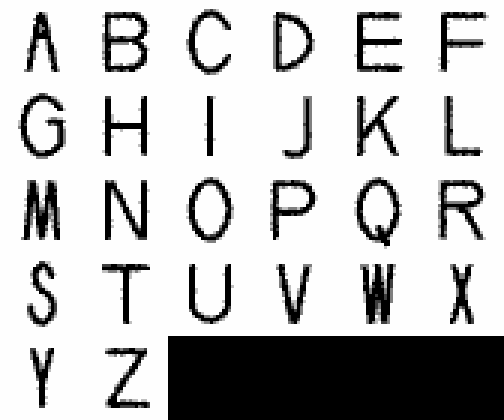

SansSerifFontRL with params:
  0 Height: 0.7645385265350342 (0.6982213854789734)
  1 Slant: 0.8300079107284546 (0.39271318912506104)
  2 Midline: 0.0 (0.5)
  3 Stroke width: -1.0 (0.07454594224691391)
  4 Bowl curvature: 0.0 (0.5)
  5 Width, AV: 0.2017906904220581 (0.5727633237838745)
  6 Width, BPR: 1.0 (0.7445056438446045)
  7 Width, D: 0.587282657623291 (0.6606043577194214)
  8 Width, EF: 0.8815429210662842 (0.7217847108840942)
  9 Width, CGOQ: 1.0 (0.7445056438446045)
  10 Width, HNU: 0.8691961765289307 (0.7193495631217957)
  11 Width, J: 0.18715929985046387 (0.5693210363388062)
  12 Width, K: 0.7388088703155518 (0.6928985714912415)
  13 Width, L: 0.13543057441711426 (0.5571156740188599)
  14 Width, M: 0.4821881055831909 (0.6373512148857117)
  15 Width, S: -0.1411910057067871 (0.49152272939682007)
  16 Width, TZ: 0.7708858251571655 (0.699526846408844)
  17 Width, W: 0.14780890941619873 (0.5600408315658569)
  18 Width, XY: -0.46683990955352783 (0.4160962700843811)
  19 Width n diffe

In [499]:
# learn = None
learner = None
gc.collect()

if 'ocr_model' not in locals() or ocr_model is None:
    ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                               df=get_combined_az_and_tmnist_df)

cb = DebugCB(vocal=False)
learner, _ = create_vector_learner(cbs=cb,
                                   # folder="results/test_8_whole_alphabet_Adam",
                                   ocr_model=ocr_model,
                                   n_colors_out=1,
                                   normalise=False,
                                   lr=1e-2, 
                                   debug=False,
                                   init_range=1., # Use smaller range to get values closer to mean
                                   seed=42)

learner.set_param("Aperture, CGS", -0)
learner.set_param("Aperture, J", -1)
learner.set_param("Bowl aspect ratio, BPR", 0.)
learner.set_param("Stroke width", -1.)
learner.set_param("Width, BPR", 1.)
learner.set_param("Width, CGOQ", 1.)
learner.set_param("Midline", 0.)
learner.set_param("Bowl curvature", 0.)
learner.set_param("Arm-leg connection location, K", 0.)
learner.set_param("Stem xp offset from vertical, M", 2.)
learner.set_param("Leg-bowl connection location, R", 1.)
learner.set_param("Leg distortion, R", 4.)
learner.set_param("Upper bowl ratio to lower, S", 1.)

with debug(learner.model, False):
    display(image_grid([learner.render_letter(l, scale=3) for l in VOCAB_UC], cols=6))

learner.model

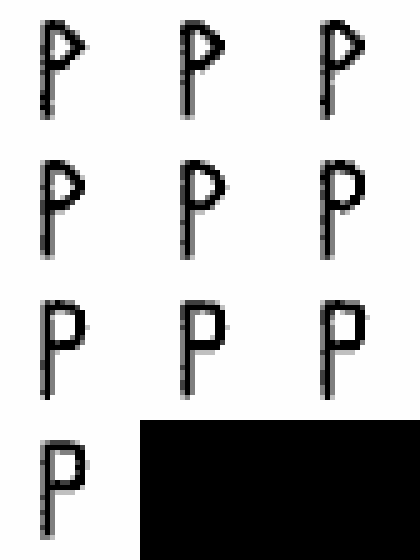

In [114]:
n = 10
imgs = []
for i in range(n):
    v = -4. + i * 8. / (n - 1)
    learner.set_param("Bowl curvature", v)
    imgs.append(learner.render_letter("B", scale=5))
image_grid(imgs)

In [93]:
learner.model

SansSerifFontRL with params:
  0 Height: 0.7645385265350342 (0.6982213854789734)
  1 Slant: 0.8300079107284546 (0.39271318912506104)
  2 Midline: -0.23427248001098633 (0.44169825315475464)
  3 Bowl curvature: 4.0 (0.9820137619972229)
  4 Width, AV: -0.21910357475280762 (0.47317007184028625)
  5 Width, BPR: 0.2017906904220581 (0.5727633237838745)
  6 Offset xp from symmetry, AXZ: -0.48685503005981445 (-0.059682637453079224)
  7 Overshoot, AMNVW: 0.587282657623291 (0.07137072086334229)
  8 Crossbar y offset, A: 0.8815429210662842 (0.20714181661605835)
  9 Bowl aspect ratio, BPR: -0.7336281538009644 (0.6487981081008911)
  10 Bowl distortion, BPR: 0.8691961765289307 (0.7045784592628479)
  11 Crossbar y offset, B: 0.18715929985046387 (0.04665374755859375)
  12 Upper bowl xn offset, B: 0.7388088703155518 (0.08836767077445984)
  13 Stroke width: 0.13543057441711426 (0.13811343908309937)

## Export

In [5]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
